Using device: cpu
Found 2879 images and 2879 masks.

===== Fold 1 =====


Fold 1 Train Epoch 1: 100%|██████████████████████████████████████████████| 960/960 [07:01<00:00,  2.28it/s, loss=0.721]


Epoch 1: Train Loss = 0.7213, Val Dice = 0.5642


Fold 1 Train Epoch 2: 100%|██████████████████████████████████████████████| 960/960 [06:53<00:00,  2.32it/s, loss=0.539]


Epoch 2: Train Loss = 0.5395, Val Dice = 0.6592


Fold 1 Train Epoch 3: 100%|██████████████████████████████████████████████| 960/960 [06:20<00:00,  2.52it/s, loss=0.458]


Epoch 3: Train Loss = 0.4583, Val Dice = 0.6834


Fold 1 Train Epoch 4: 100%|██████████████████████████████████████████████| 960/960 [06:15<00:00,  2.56it/s, loss=0.406]


Epoch 4: Train Loss = 0.4058, Val Dice = 0.7122


Fold 1 Train Epoch 5: 100%|██████████████████████████████████████████████| 960/960 [06:16<00:00,  2.55it/s, loss=0.373]


Epoch 5: Train Loss = 0.3728, Val Dice = 0.7068
Saved metrics to results_fold1.csv
Showing predictions for 3 samples from validation set...


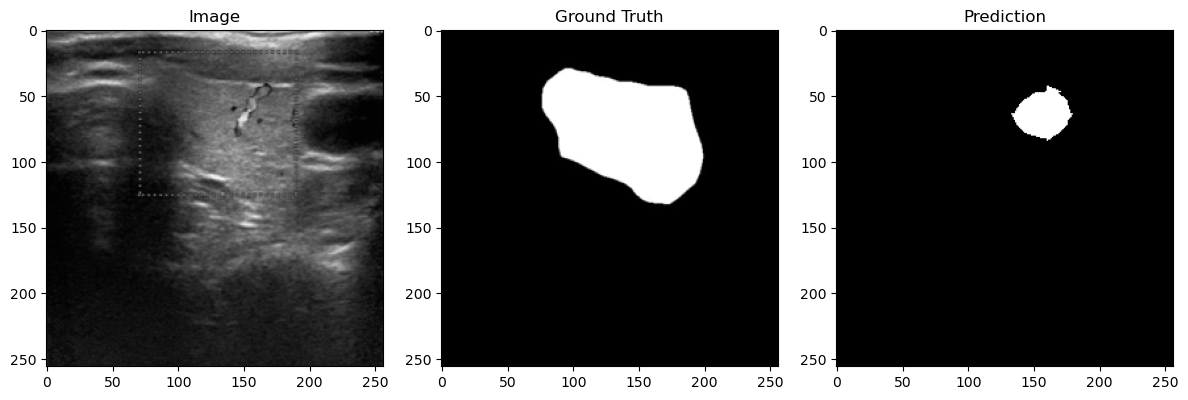

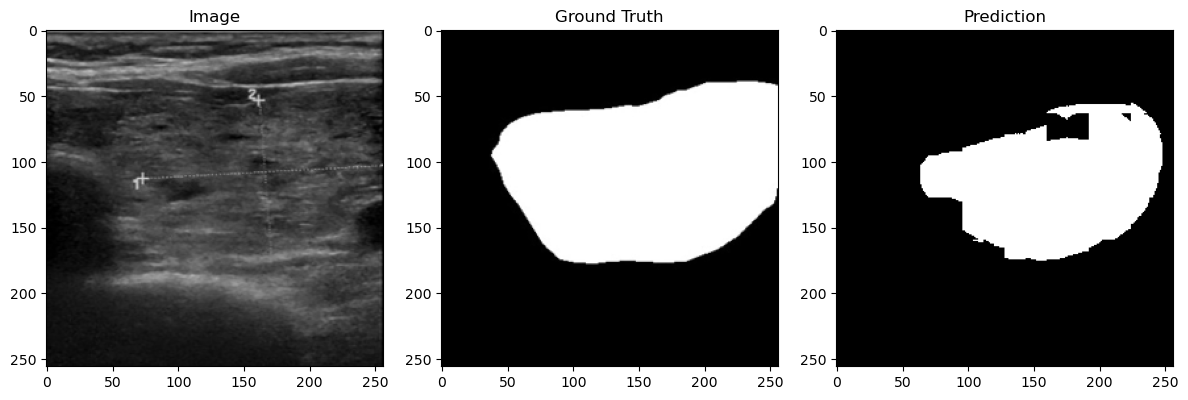

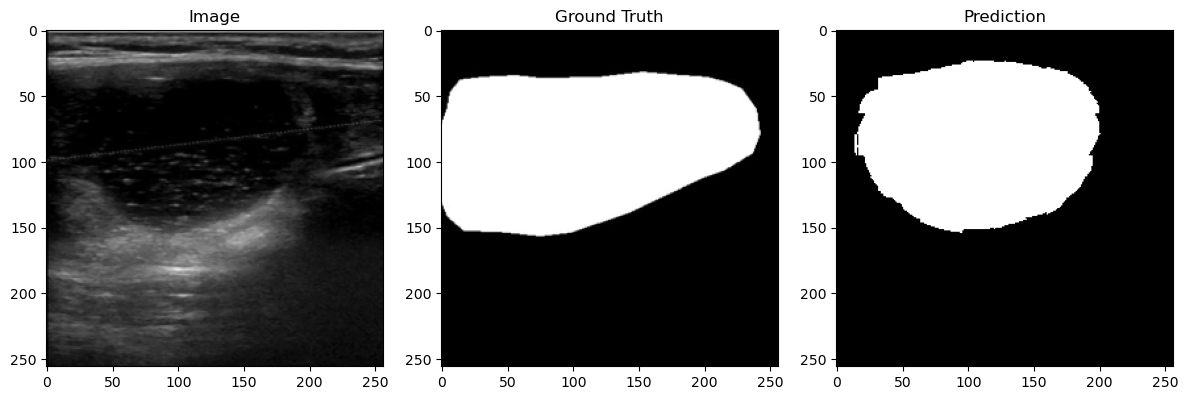

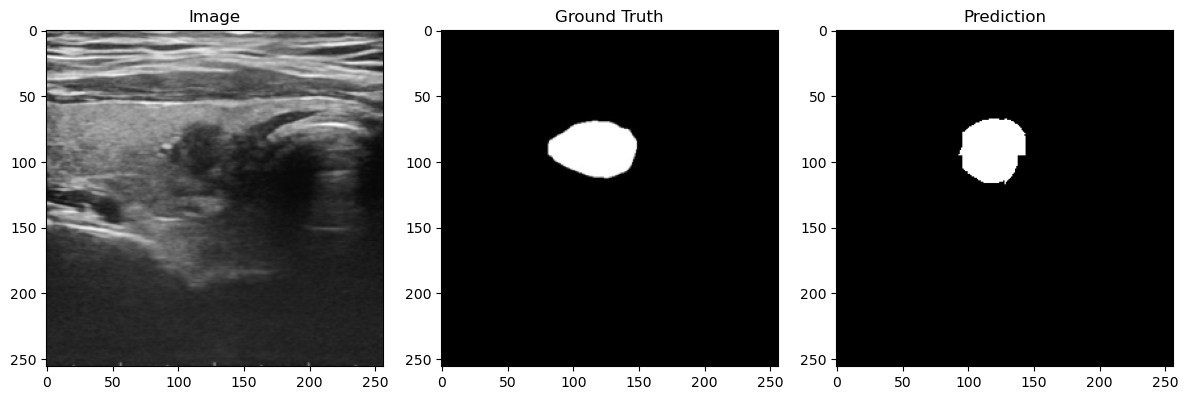


===== Fold 2 =====


Fold 2 Train Epoch 1: 100%|██████████████████████████████████████████████| 960/960 [06:25<00:00,  2.49it/s, loss=0.729]


Epoch 1: Train Loss = 0.7294, Val Dice = 0.5521


Fold 2 Train Epoch 2: 100%|███████████████████████████████████████████████| 960/960 [06:15<00:00,  2.56it/s, loss=0.55]


Epoch 2: Train Loss = 0.5497, Val Dice = 0.6052


Fold 2 Train Epoch 3: 100%|███████████████████████████████████████████████| 960/960 [06:15<00:00,  2.55it/s, loss=0.48]


Epoch 3: Train Loss = 0.4803, Val Dice = 0.6662


Fold 2 Train Epoch 4: 100%|██████████████████████████████████████████████| 960/960 [06:16<00:00,  2.55it/s, loss=0.423]


Epoch 4: Train Loss = 0.4227, Val Dice = 0.6763


Fold 2 Train Epoch 5: 100%|██████████████████████████████████████████████| 960/960 [06:21<00:00,  2.52it/s, loss=0.385]


Epoch 5: Train Loss = 0.3847, Val Dice = 0.6787
Saved metrics to results_fold2.csv
Showing predictions for 3 samples from validation set...


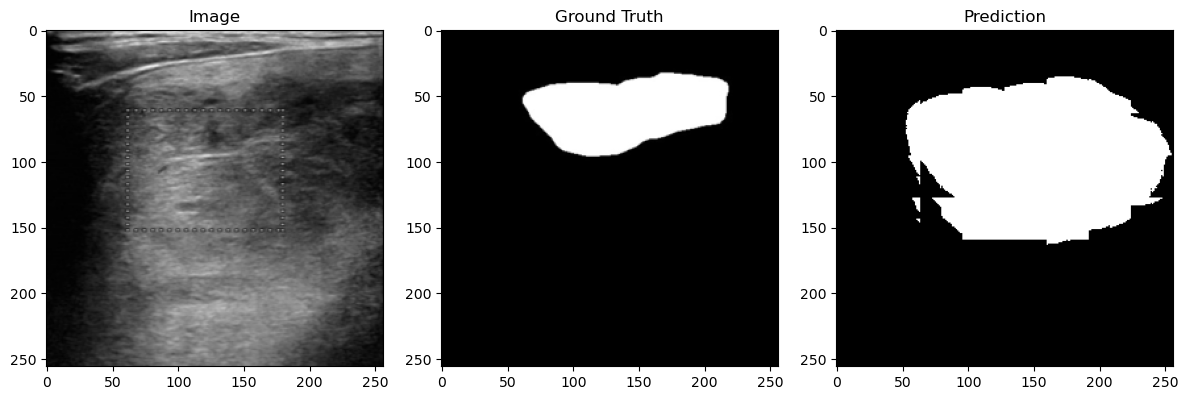

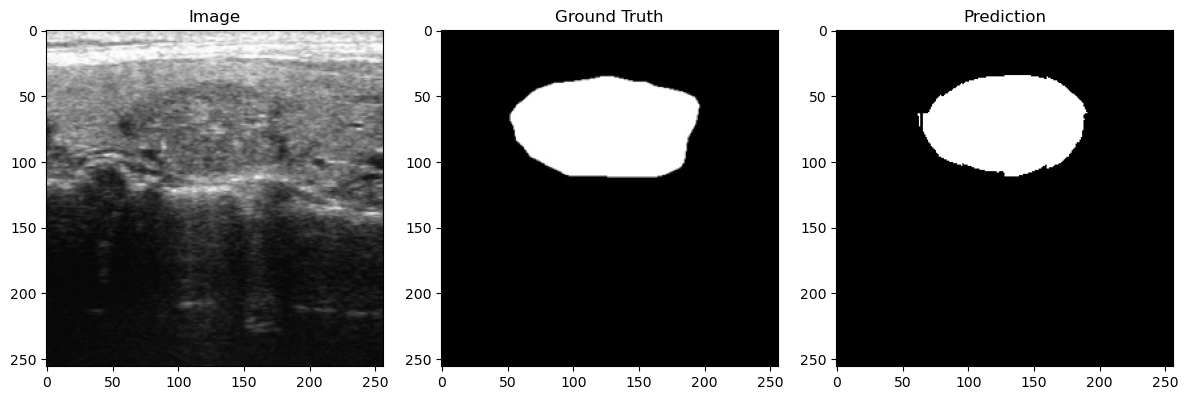

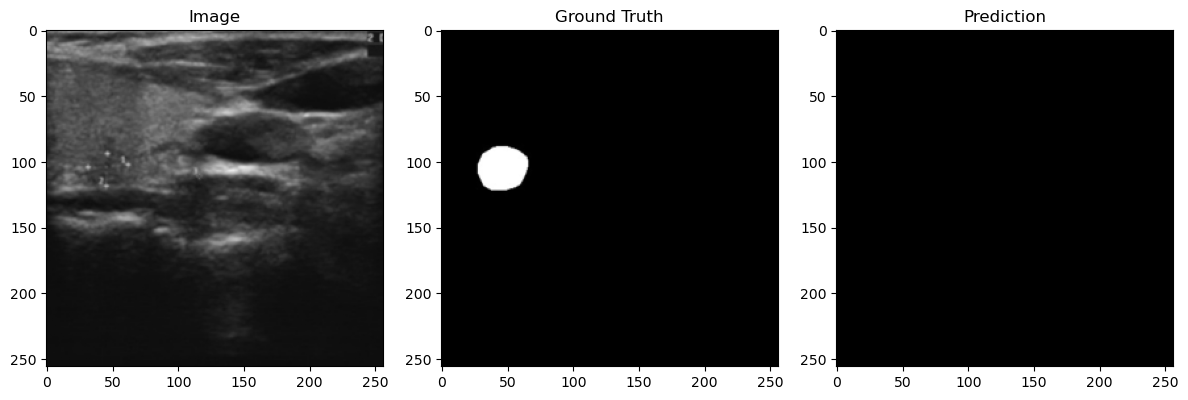

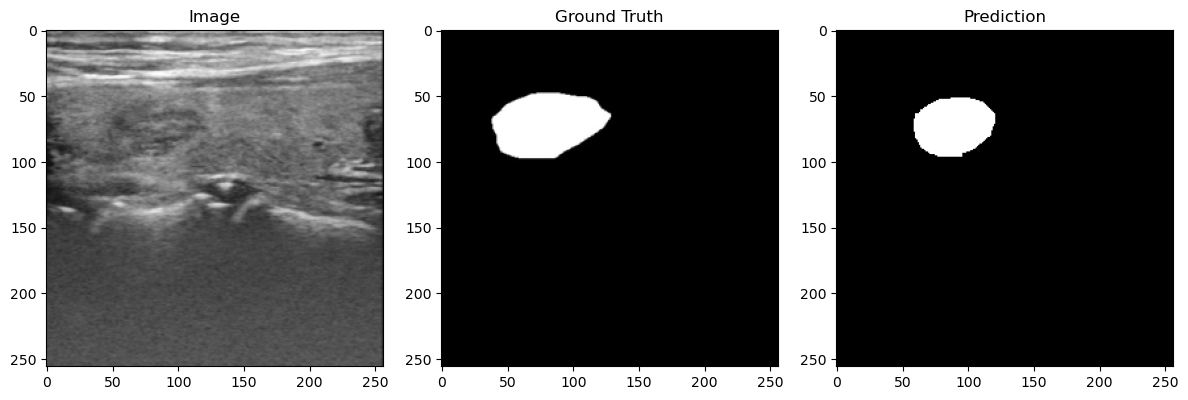


===== Fold 3 =====


Fold 3 Train Epoch 1: 100%|██████████████████████████████████████████████| 960/960 [06:17<00:00,  2.54it/s, loss=0.816]


Epoch 1: Train Loss = 0.8161, Val Dice = 0.4822


Fold 3 Train Epoch 2: 100%|██████████████████████████████████████████████| 960/960 [06:52<00:00,  2.33it/s, loss=0.615]


Epoch 2: Train Loss = 0.6147, Val Dice = 0.5595


Fold 3 Train Epoch 3: 100%|███████████████████████████████████████████████| 960/960 [07:54<00:00,  2.02it/s, loss=0.52]


Epoch 3: Train Loss = 0.5204, Val Dice = 0.6719


Fold 3 Train Epoch 4: 100%|██████████████████████████████████████████████| 960/960 [07:35<00:00,  2.11it/s, loss=0.451]


Epoch 4: Train Loss = 0.4506, Val Dice = 0.6805


Fold 3 Train Epoch 5: 100%|██████████████████████████████████████████████| 960/960 [06:18<00:00,  2.54it/s, loss=0.412]


Epoch 5: Train Loss = 0.4117, Val Dice = 0.7051
Saved metrics to results_fold3.csv
Showing predictions for 3 samples from validation set...


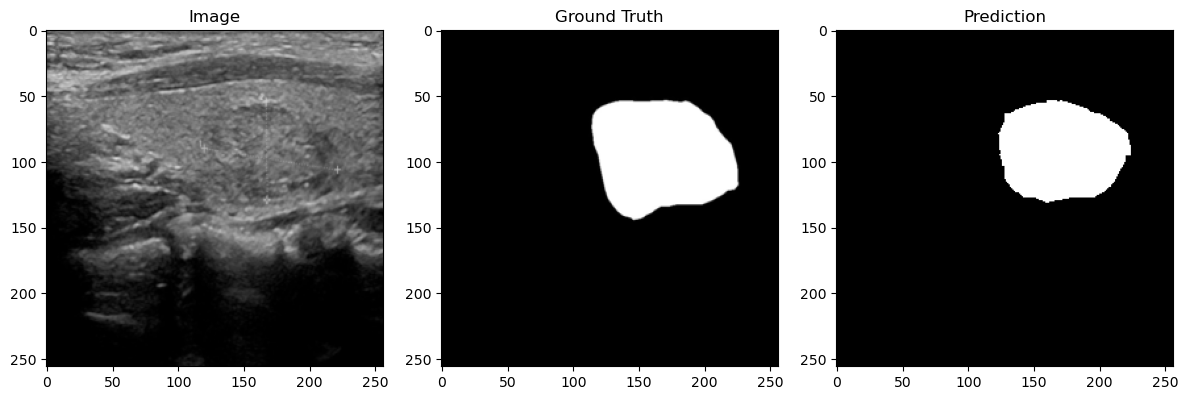

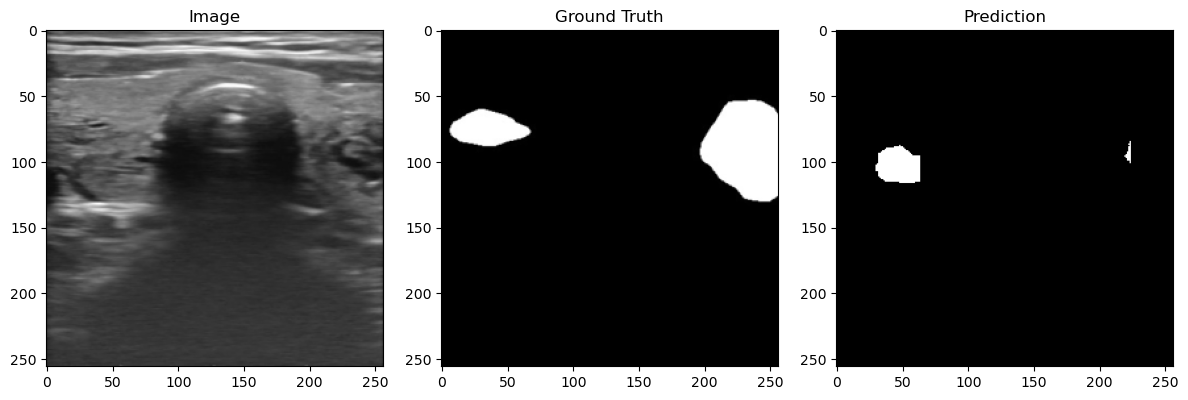

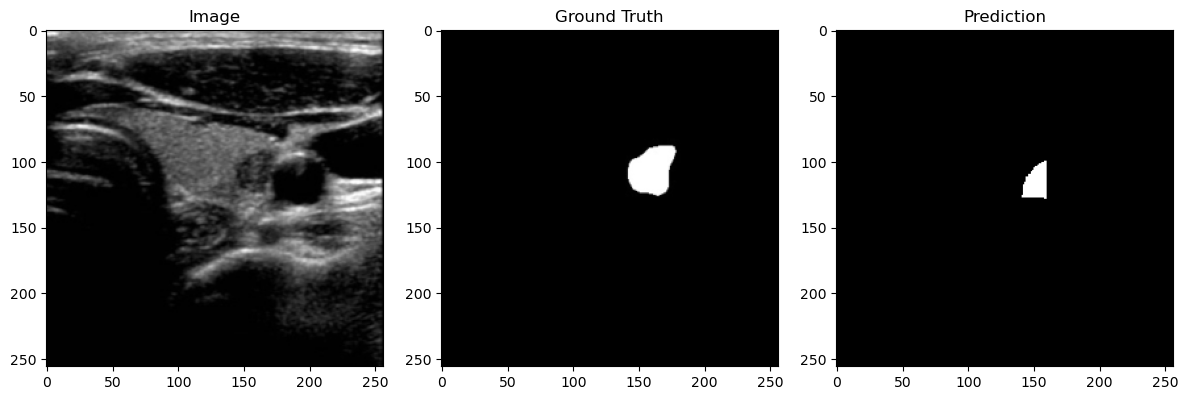

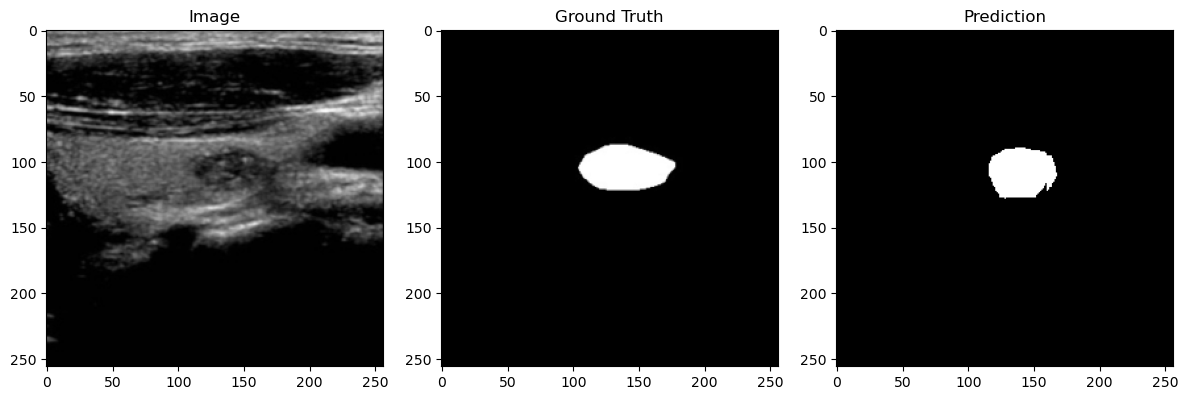

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
from sklearn.model_selection import KFold
from tqdm import tqdm
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision import models
import torch.nn.functional as F

# 设置设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# 自定义数据集
class ThyroidDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform or transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")
        mask = Image.open(self.mask_paths[idx]).convert("L")
        return self.transform(image), self.transform(mask)

# SE注意力机制
class SEBlock(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super(SEBlock, self).__init__()
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Conv2d(in_channels, in_channels // reduction, 1),
            nn.ReLU(),
            nn.Conv2d(in_channels // reduction, in_channels, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        w = self.pool(x)
        w = self.fc(w)
        return x * w

# 带SE模块的ResUNet
class ResUNet(nn.Module):
    def __init__(self):
        super().__init__()
        base = models.resnet18(weights="IMAGENET1K_V1")
        self.enc = nn.Sequential(*list(base.children())[:-2])
        self.se = SEBlock(512)
        self.up1 = nn.ConvTranspose2d(512, 256, 2, 2)
        self.up2 = nn.ConvTranspose2d(256, 128, 2, 2)
        self.up3 = nn.ConvTranspose2d(128, 64, 2, 2)
        self.up4 = nn.ConvTranspose2d(64, 32, 2, 2)
        self.up5 = nn.ConvTranspose2d(32, 16, 2, 2)
        self.out = nn.Conv2d(16, 1, kernel_size=1)

    def forward(self, x):
        x = self.enc(x)
        x = self.se(x)
        x = self.up1(x)
        x = self.up2(x)
        x = self.up3(x)
        x = self.up4(x)
        x = self.up5(x)
        x = self.out(x)
        return torch.sigmoid(x)

# 指标与损失函数
def dice_coef(pred, target, smooth=1e-5):
    pred = pred.view(-1)
    target = target.view(-1)
    inter = (pred * target).sum()
    return (2. * inter + smooth) / (pred.sum() + target.sum() + smooth)

def bce_dice_loss(pred, target):
    bce = F.binary_cross_entropy(pred, target)
    dice = dice_coef(pred, target)
    return bce + (1 - dice)

# 可视化样本
def show_sample(image, true_mask, pred_mask):
    fig, ax = plt.subplots(1, 3, figsize=(12, 4))
    ax[0].imshow(image.permute(1, 2, 0).cpu())
    ax[0].set_title("Image")
    ax[1].imshow(true_mask.squeeze().cpu(), cmap='gray')
    ax[1].set_title("Ground Truth")
    ax[2].imshow(pred_mask.squeeze().cpu(), cmap='gray')
    ax[2].set_title("Prediction")
    plt.tight_layout()
    plt.show()

# 数据路径（根据你的文件夹结构修改）
img_dir = r"D:\tn3k\trainval-image"
mask_dir = r"D:\tn3k\trainval-mask"
image_paths = sorted([os.path.join(img_dir, f) for f in os.listdir(img_dir) if f.lower().endswith((".jpg", ".png"))])
mask_paths = sorted([os.path.join(mask_dir, f) for f in os.listdir(mask_dir) if f.lower().endswith((".jpg", ".png"))])

print(f"Found {len(image_paths)} images and {len(mask_paths)} masks.")

# 交叉验证
kf = KFold(n_splits=3, shuffle=True, random_state=42)
for fold, (train_idx, val_idx) in enumerate(kf.split(image_paths)):
    print(f"\n===== Fold {fold + 1} =====")
    train_ds = ThyroidDataset([image_paths[i] for i in train_idx], [mask_paths[i] for i in train_idx])
    val_ds = ThyroidDataset([image_paths[i] for i in val_idx], [mask_paths[i] for i in val_idx])
    train_dl = DataLoader(train_ds, batch_size=2, shuffle=True)
    val_dl = DataLoader(val_ds, batch_size=2)

    model = ResUNet().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    train_losses, val_dices = [], []

    for epoch in range(5):
        model.train()
        running_loss = 0
        loop = tqdm(train_dl, desc=f"Fold {fold+1} Train Epoch {epoch+1}")
        for img, mask in loop:
            img, mask = img.to(device), mask.to(device)
            optimizer.zero_grad()
            pred = model(img)
            loss = bce_dice_loss(pred, mask)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            loop.set_postfix(loss=running_loss / (loop.n + 1))

        train_losses.append(running_loss / len(train_dl))

        model.eval()
        dices = []
        with torch.no_grad():
            for img, mask in val_dl:
                img, mask = img.to(device), mask.to(device)
                pred = model(img)
                dice = dice_coef(pred, mask)
                dices.append(dice.item())
        val_dices.append(np.mean(dices))

        print(f"Epoch {epoch+1}: Train Loss = {train_losses[-1]:.4f}, Val Dice = {val_dices[-1]:.4f}")

    # 保存指标为 CSV
    df = pd.DataFrame({
        "epoch": list(range(1, len(train_losses)+1)),
        "train_loss": train_losses,
        "val_dice": val_dices
    })
    df.to_csv(f"results_fold{fold+1}.csv", index=False)
    print(f"Saved metrics to results_fold{fold+1}.csv")

    # 可视化验证样本
    model.eval()
    print("Showing predictions for 3 samples from validation set...")
    shown = 0
    with torch.no_grad():
        for img, mask in val_dl:
            img, mask = img.to(device), mask.to(device)
            pred = model(img)
            for i in range(min(3, img.size(0))):
                show_sample(img[i], mask[i], (pred[i] > 0.5).float())
                shown += 1
            if shown >= 3:
                break
